## VirES - magnetic model benchmark - results viewer

Assess perfomance of the VirES magnetic model evaluation and other parameters wrt. the plain data rerival. 
Get per sample times.

See also [VirES Python Client](https://github.com/ESA-VirES/VirES-Python-Client)

In [1]:
import pandas as pd
import json

LABELS = [
    "plain request",
    "plain request (cached)",
    "filter: Flags_B != 255",
    "aux.var.: MLT,  QDLat",
    "aux.var.: MLT, QDLat",
    "model: CHAOS",
    "model: CHAOS80",
    "model: CHAOS-Static",
    "model: CHAOS-Static80",
    "model: CHAOS-Core",
    "model: CHAOS-MMA",
    "model: CHAOS-MMA-Primary",
    "model: CHAOS-MMA-Secondary",
    "model: MIO_SHA_2C",
    "model: MIO_SHA_2C-Primary",
    "model: MIO_SHA_2C-Secondary",
]

LABEL_ORDER = {label: index for index, label in enumerate(LABELS, 1)}


def load_data_form_json_log(filename):
    records = []
    with open(filename, encoding="utf8") as input_file:
        for line in input_file:
            record = json.loads(line)
            record["_labelSortingIndex"] = LABEL_ORDER.get(record["description"], 0)
            records.append(record)
    df = pd.DataFrame(records)
    df = df.sort_values('_labelSortingIndex')
    return df


In [2]:
from numpy import isnan
from matplotlib.pyplot import figure, subplot, colorbar
from matplotlib.colors import LogNorm

def plot_data(ax, df, label):
    y = df['description'].values
    x = 1e3 * df['requestDuration'].values / df['numberOfSamples'].values
    c = df['numberOfSamples'].values
    m = df['numberOfSamples'].values > 1e3
    ax.set_axisbelow(True)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.yaxis.grid(color='whitesmoke', linestyle='dashed')
    h = ax.scatter(x[m], y[m], s=3, c=c[m], norm=LogNorm(1e3, 1e6), cmap='viridis_r')
    ax.set_xlabel("request duration per 1k samples / s")
    ax.set_title(label)
    ax.semilogx()
    cax = colorbar(h)
    ax.set_xlim([1e-3, 1e1])


/tmp/ipykernel_454/2593348926.py:7: RuntimeWarning: divide by zero encountered in true_divide
  x = 1e3 * df['requestDuration'].values / df['numberOfSamples'].values


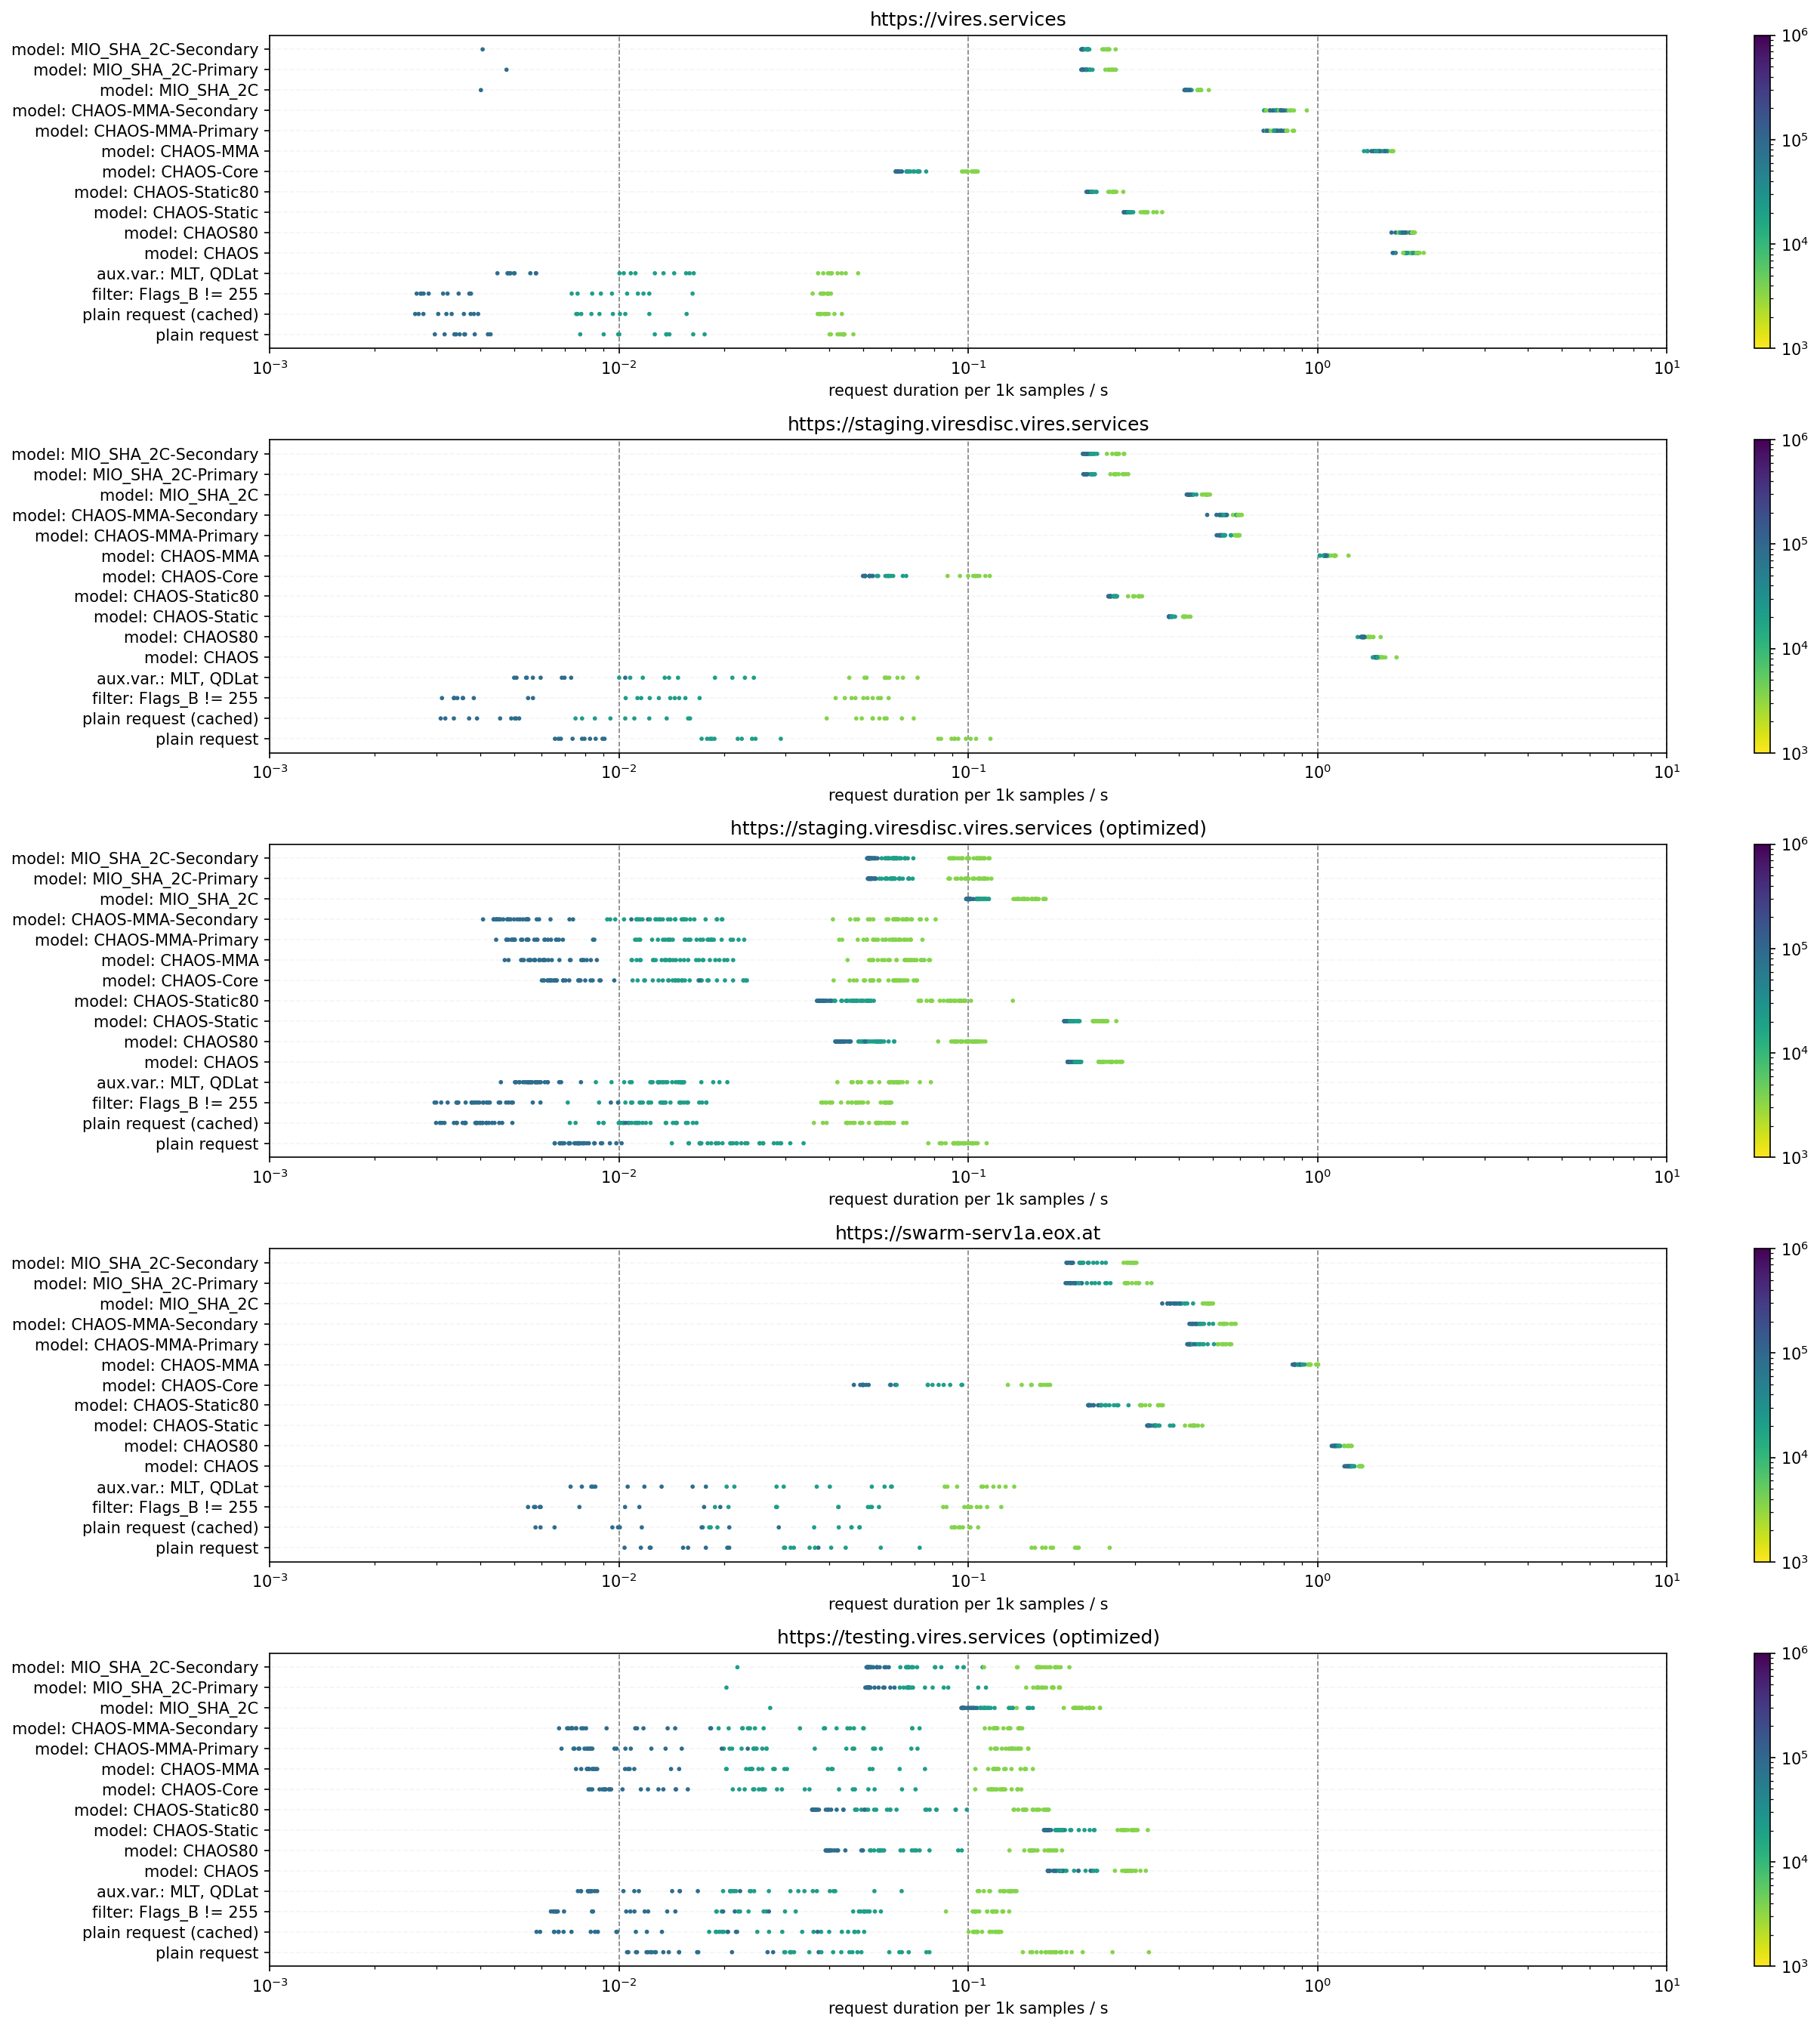

In [3]:
# initialial optimization results

df_production = load_data_form_json_log("results/2022-11-14_production_benchmark.log")
df_failover = load_data_form_json_log("results/2022-11-14_failover_benchmark.log")
df_testing = load_data_form_json_log("results/2022-11-17_testing_benchmark.log")
df_staging = load_data_form_json_log("results/2022-11-14_staging_benchmark.log")
df_disc_orig = load_data_form_json_log("results/2022-11-14_disc_benchmark.log")
df_disc = load_data_form_json_log("results/2022-11-21_disc_benchmark.log")


fig = figure(figsize=(18, 18), dpi=150)

ax = subplot(5, 1, 1)
plot_data(ax, df_production, "https://vires.services")

ax = subplot(5, 1, 2)
plot_data(ax, df_disc_orig, "https://staging.viresdisc.vires.services")

ax = subplot(5, 1, 3)
plot_data(ax, df_disc, "https://staging.viresdisc.vires.services (optimized)")

ax = subplot(5, 1, 4)
plot_data(ax, df_failover, "https://swarm-serv1a.eox.at")
#plot_data(ax, df_staging, "https://staging.vires.services")

ax = subplot(5, 1, 5)
plot_data(ax, df_testing, "https://testing.vires.services (optimized)")




fig.tight_layout()

In [4]:
from numpy import isnan, asarray, log, exp
from matplotlib.pyplot import figure, subplot, colorbar
from matplotlib.colors import LogNorm


def average(df):
    df = df.groupby(['description'])[['description', 'requestDuration']].mean()
    df["_labelSortingIndex"] = list(map(lambda label: LABEL_ORDER.get(label, 0), df.index))
    df = df.sort_values('_labelSortingIndex')
    return df


def median(df):
    df = df.groupby(['description'])[['description', 'requestDuration']].median()
    df["_labelSortingIndex"] = list(map(lambda label: LABEL_ORDER.get(label, 0), df.index))
    df = df.sort_values('_labelSortingIndex')
    return df


def plot_data_1d(ax, df, label, color):
    df = df.copy()
    df['_labelSortingIndex'] = -df['_labelSortingIndex']
    df = df.sort_values('_labelSortingIndex')
    
    y = df['description'].values
    # = 1e3 * df['requestDuration'].values / df['numberOfSamples'].values
    x = df['requestDuration'].values
    c = df['numberOfSamples'].values
    m = (
        df['numberOfSamples'].values > 23 * 60 * 60
    ) & (
        asarray(["model" in value for value in df['description'].values])
        #df['description'].values != "plain request"
    )
    ax.set_axisbelow(True)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.yaxis.grid(color='whitesmoke', linestyle='dashed')
    
    #df_mean = average(df[m])
    df_mean = median(df[m])
    df_mean['_labelSortingIndex'] = -df_mean['_labelSortingIndex']
    df_mean = df_mean.sort_values('_labelSortingIndex')

    x_mean = df_mean.requestDuration.values
    y_mean = df_mean.index.values

    h_mean = ax.scatter(x_mean, y_mean, s=100, c=color, marker='|')
    h = ax.scatter(x[m], y[m], s=3, c=color)
    ax.set_xlabel("request duration / s")
    ax.set_title(label)
    ax.semilogx()
    #cax = colorbar(h)
    ax.set_xlim([1e-1, 1e3])
    
    return h, h_mean, df_mean

## Performance improvement on testing/staging instances

,requestDurationBefore,requestDurationAfter,speedUp,_labelSortingIndex
description,,,,
model: MIO_SHA_2C-Secondary,17.242855,4.533863,3.803127,-16
model: MIO_SHA_2C-Primary,17.305554,4.492581,3.852030,-15
model: MIO_SHA_2C,33.283798,8.421961,3.952025,-14
model: CHAOS-MMA-Secondary,38.103107,0.678560,56.152865,-13
model: CHAOS-MMA-Primary,38.305080,0.720623,53.155481,-12
model: CHAOS-MMA,75.687931,0.726563,104.172570,-11
model: CHAOS-Core,4.568278,0.810234,5.638223,-10
model: CHAOS-Static80,19.668374,3.180733,6.183597,-9
model: CHAOS-Static,28.859214,14.453981,1.996627,-8


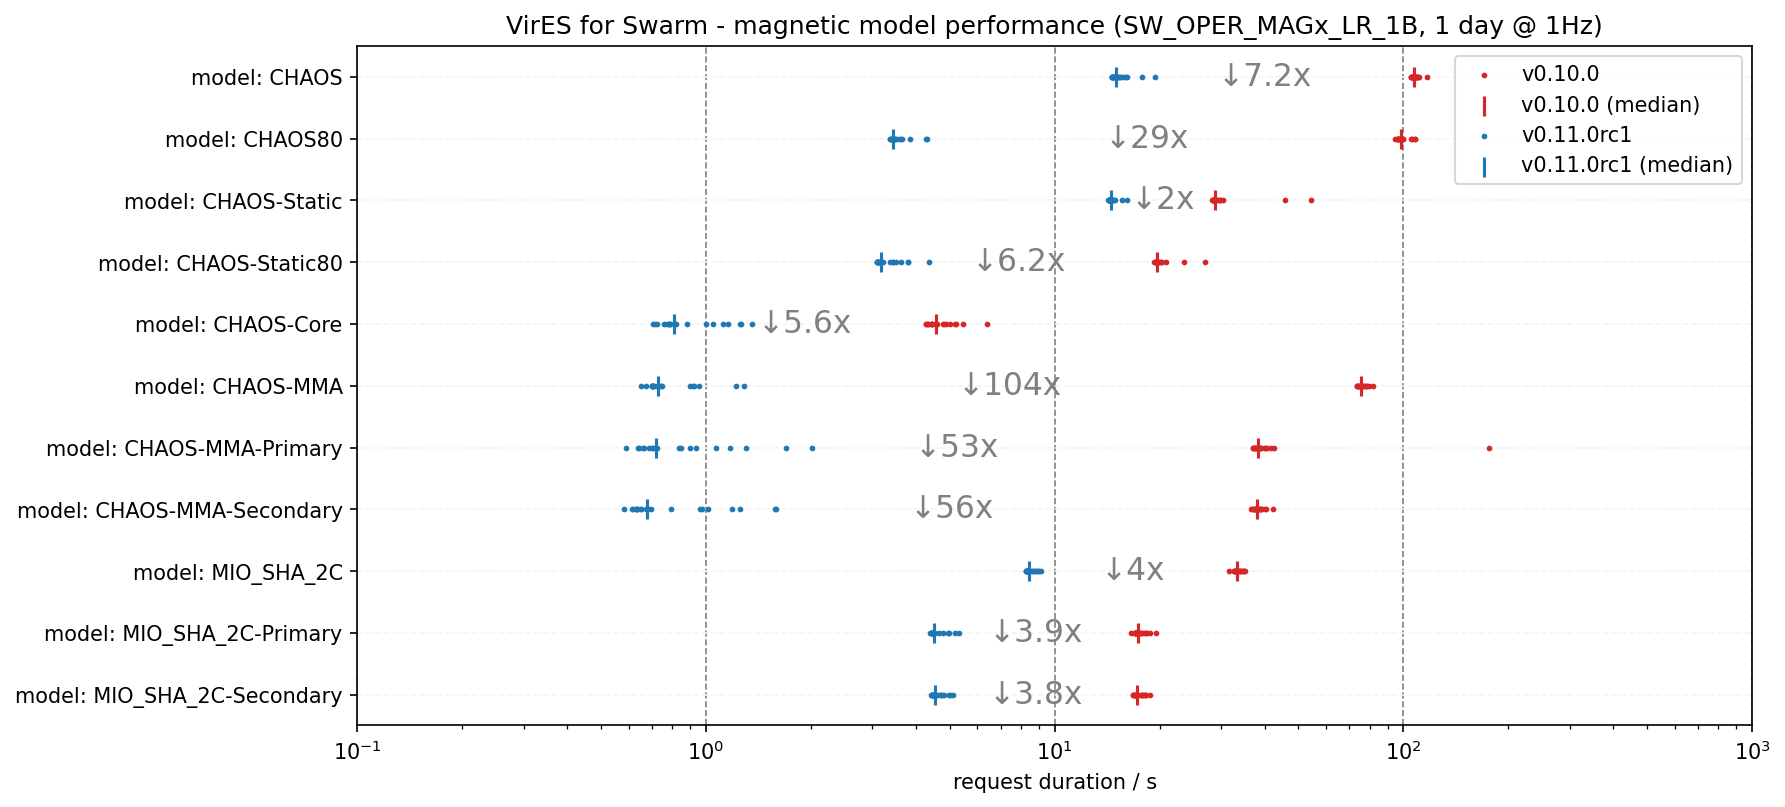

In [5]:
df_testing = load_data_form_json_log("results/2022-11-17_testing_benchmark.log")
df_staging = load_data_form_json_log("results/2022-11-14_staging_benchmark.log")

fig = figure(figsize=(12, 6), dpi=150)

ax = subplot(1, 1, 1)
h0, h0_mean, df0_mean = plot_data_1d(ax, df_staging, "https://staging.vires.services", color="tab:red")
h1, h1_mean, df1_mean = plot_data_1d(ax, df_testing, "https://testing.vires.services", color="tab:blue")

ax.set_title("VirES for Swarm - magnetic model performance (SW_OPER_MAGx_LR_1B, 1 day @ 1Hz)")
ax.legend(
    [h0, h0_mean, h1, h1_mean],
    ["v0.10.0", "v0.10.0 (median)", "v0.11.0rc1", "v0.11.0rc1 (median)" ]

)

df_comp = df0_mean[[]].copy()

df_comp['requestDurationBefore'] = df0_mean['requestDuration']
df_comp['requestDurationAfter'] = df1_mean['requestDuration']
df_comp['speedUp'] = df0_mean['requestDuration'] / df1_mean['requestDuration']
df_comp['_labelSortingIndex'] = df1_mean['_labelSortingIndex']

y_label = df_comp.index
x_label = exp(0.5*log(df_comp['requestDurationBefore'].values) + 0.5*log(df_comp['requestDurationAfter'].values))
v_label = df_comp['speedUp'].values

for i, (x, y, v) in enumerate(zip(x_label, y_label, v_label)):
    if v > 10: v = round(v)
    else: v = round(v, 1)
    ax.text(x, i, f"↓{v:g}x", va="center", ha="center", fontsize=15, color='gray')

df_comp

## Performance improvement on DISC instances

,requestDurationBefore,requestDurationAfter,speedUp,_labelSortingIndex
description,,,,
model: MIO_SHA_2C-Secondary,18.762365,4.501881,4.167672,-16
model: MIO_SHA_2C-Primary,18.730200,4.536310,4.128950,-15
model: MIO_SHA_2C,36.922526,8.649441,4.268776,-14
model: CHAOS-MMA-Secondary,45.673081,0.437264,104.451998,-13
model: CHAOS-MMA-Primary,45.669017,0.472442,96.665856,-12
model: CHAOS-MMA,90.678459,0.516874,175.436365,-11
model: CHAOS-Core,4.438892,0.585531,7.580969,-10
model: CHAOS-Static80,22.011524,3.275513,6.720023,-9
model: CHAOS-Static,32.450592,16.339735,1.985993,-8


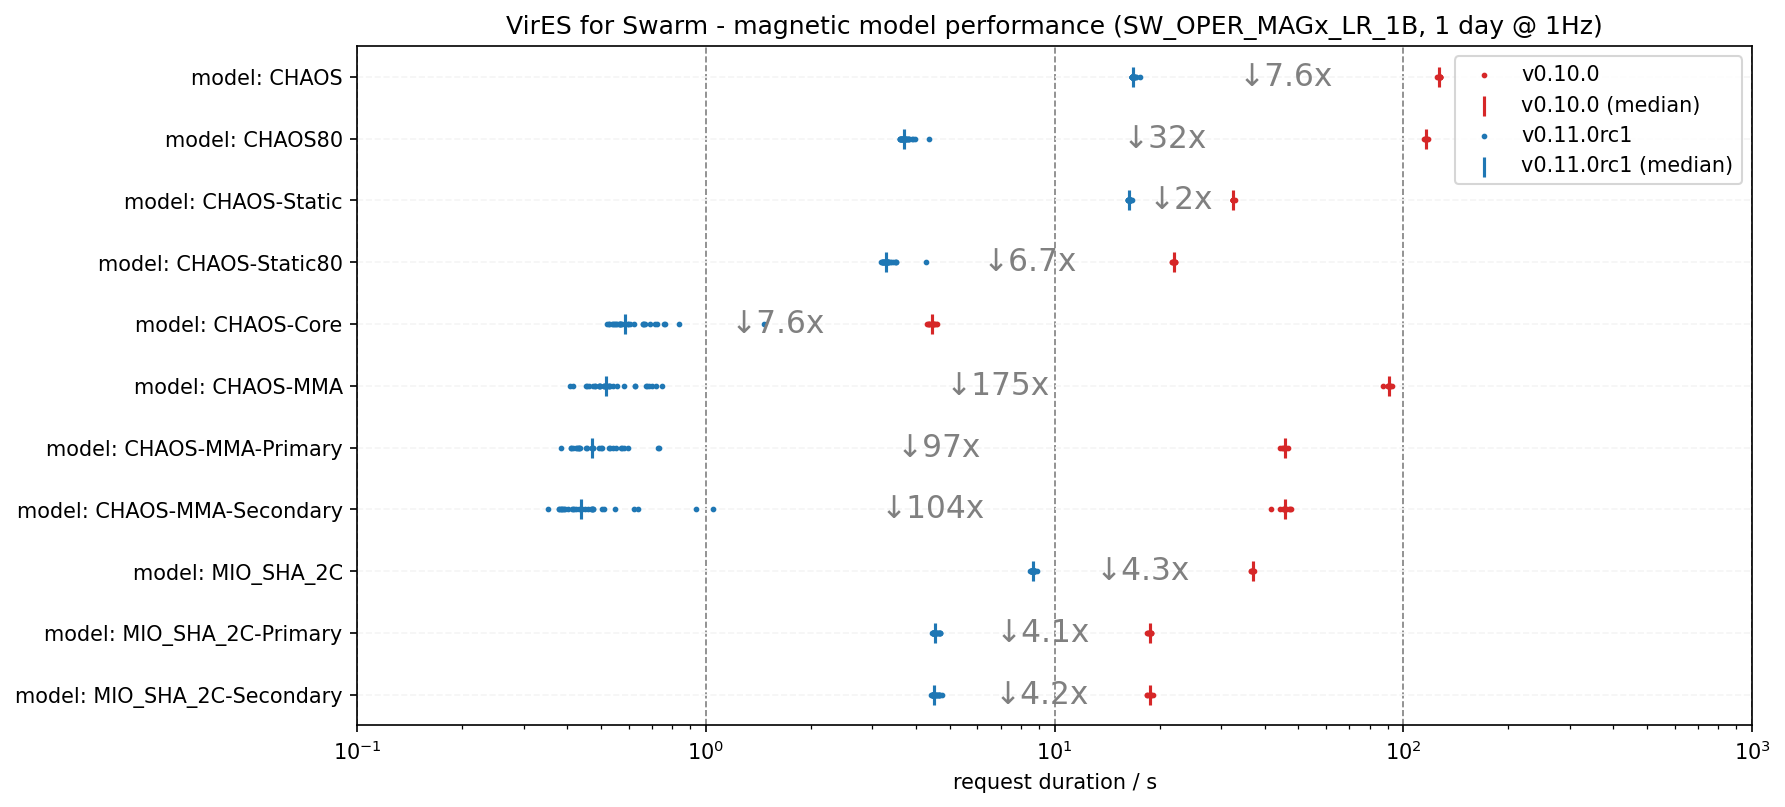

In [6]:
df_old = load_data_form_json_log("results/2022-11-14_disc_benchmark.log")
df_new = load_data_form_json_log("results/2022-11-21_disc_benchmark.log")

fig = figure(figsize=(12, 6), dpi=150)

ax = subplot(1, 1, 1)
h0, h0_mean, df0_mean = plot_data_1d(ax, df_old, "https://staging.viresdisc.vires.services", color="tab:red")
h1, h1_mean, df1_mean = plot_data_1d(ax, df_new, "https://staging.viresdisc.vires.services (optimized)", color="tab:blue")

ax.set_title("VirES for Swarm - magnetic model performance (SW_OPER_MAGx_LR_1B, 1 day @ 1Hz)")
ax.legend(
    [h0, h0_mean, h1, h1_mean],
    ["v0.10.0", "v0.10.0 (median)", "v0.11.0rc1", "v0.11.0rc1 (median)" ]

)

df_comp = df0_mean[[]].copy()

df_comp['requestDurationBefore'] = df0_mean['requestDuration']
df_comp['requestDurationAfter'] = df1_mean['requestDuration']
df_comp['speedUp'] = df0_mean['requestDuration'] / df1_mean['requestDuration']
df_comp['_labelSortingIndex'] = df1_mean['_labelSortingIndex']

y_label = df_comp.index
x_label = exp(0.5*log(df_comp['requestDurationBefore'].values) + 0.5*log(df_comp['requestDurationAfter'].values))
v_label = df_comp['speedUp'].values

for i, (x, y, v) in enumerate(zip(x_label, y_label, v_label)):
    if v > 10: v = round(v)
    else: v = round(v, 1)
    ax.text(x, i, f"↓{v:g}x", va="center", ha="center", fontsize=15, color='gray')

df_comp